In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#!/usr/bin/env python
# coding: utf-8


In [1]:
#For data processing
import pandas as pd
import numpy as np
import datetime as dt

#For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For models
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, SGD, Adam
import preprocessing 
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:

class FetchData(object):
    
    def __init__(self, data, start, end):
        '''
        Arguments:
            @data: takes in the name of the stock
                    for analysis
            @source: API from where data is fetched from
                    mostly yahoo.
            @start: Start date for data source in the format
                    e.g 
                    >>datetime(2000, 1, 1)
            @end: the end of the timeseries for data collection
                    e.g 
                    >>datetime.now()
            
       
        '''
        self.data = data
        self.start = start
        self.end = end
        self.train = False
        
    def fetch(self):
        if not self.data:
            raise ValueError('Stock name not available')
        elif not self.start or not self.end:
            raise ValueError('Start date and End date not specified')
        else:
            dataframe = yf.download(self.data, self.start, self.end)
            #dataframe = web.DataReader()
        return dataframe
       


In [3]:
df =  FetchData("SBIN.NS", datetime(2013, 1, 1),datetime(2019, 12, 31)).fetch()


[*********************100%***********************]  1 of 1 completed


In [4]:
df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,335.700012,338.850006,330.350006,332.399994,332.399994,30150335
2019-12-24,333.200012,334.200012,329.200012,331.450012,331.450012,21747782
2019-12-26,333.000000,333.450012,328.100006,329.850006,329.850006,24616942
2019-12-27,333.399994,338.350006,333.000000,337.250000,337.250000,33477173
2019-12-30,337.750000,337.850006,332.500000,334.399994,334.399994,22775554


In [5]:
train_set = df.iloc[:1500, 1:2].values
test_set = df.iloc[1500:, 1:2].values

In [6]:
sc = MinMaxScaler(feature_range = (0, 1))
train_set_scaled = sc.fit_transform(train_set)

In [7]:
#Creating a data structure with given time_steps (=5) and 1 output
# build the input features with time lag of 1 day (lag 1):

time_step = 5
X_train = []
y_train = []

for i in range(5, len(train_set)):
    X_train.append(train_set_scaled[i-time_step:i, 0])
    y_train.append(train_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)


(1495, 5) (1495,)


In [8]:
#reshape X_train to 3D array of dim sample size, time step, feature
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1495, 5, 1)


In [9]:
#build model
regressor = Sequential()
regressor.add(LSTM(units = 50, input_shape = (X_train.shape[1], 1))) #return_sequences = True
# regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [10]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0662
Epoch 2/15
47/47 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 3/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 4/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 5/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 6/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 7/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 8/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 9/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 10/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 11/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 12/15
47/47 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 13/15
47/47 [==============================

In [11]:
# Getting the predicted stock price of 
dataset_train = df.iloc[:1500, 1:2]
dataset_test = df.iloc[1500:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

#input should also have the same time_step as the model
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_step:].values

inputs.shape

(224, 1)

In [34]:
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_step, len(inputs)):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(219, 5, 1)


In [35]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [36]:
predicted_stock_price.shape

(219, 1)

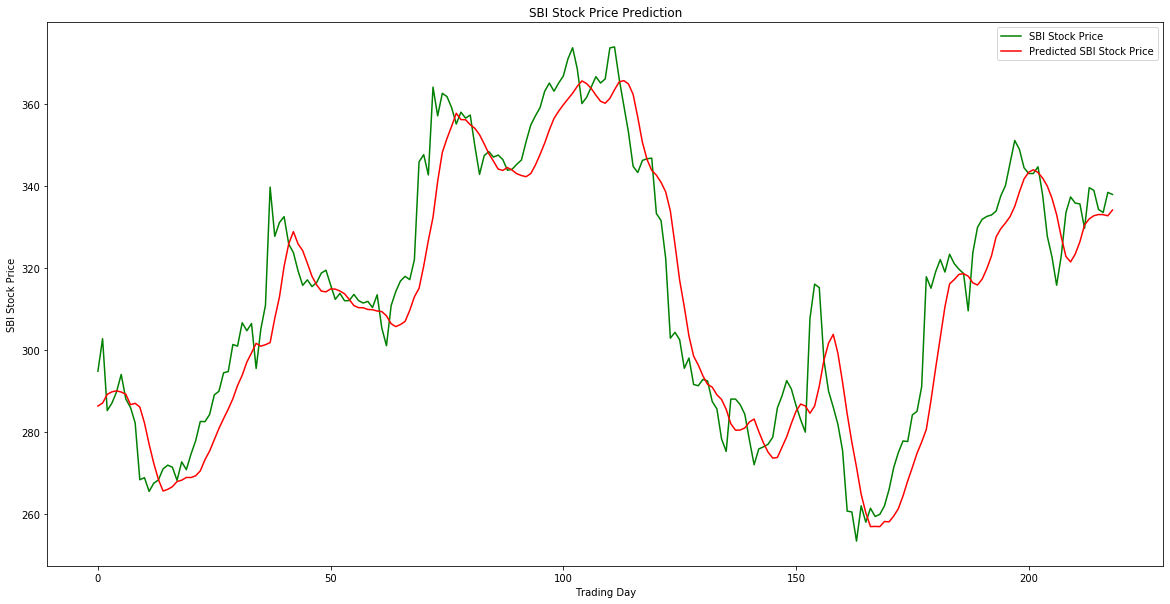

In [37]:
# Visualising the results

plt.figure(figsize=(20,10))
plt.plot(dataset_test.values, color = 'green', label = 'SBI Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted SBI Stock Price')
plt.title('SBI Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('SBI Stock Price')
plt.legend()
plt.show()